Total # images to process = 10


$$$----Reading Image img/0000.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (844, 1181, 3) %%%%


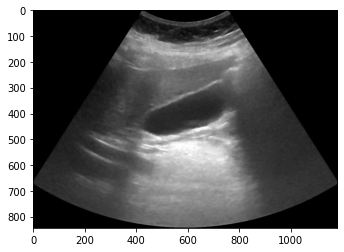



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (844, 1181) %%%%


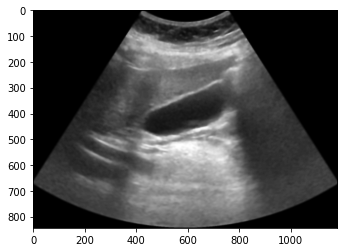



%%%% IMAGE: Default, SHAPE: (844, 1181) %%%%


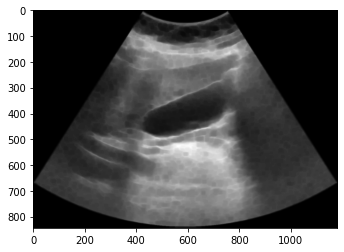

saving mask: 0000.png


$$$----Reading Image img/0001.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (844, 1168, 3) %%%%


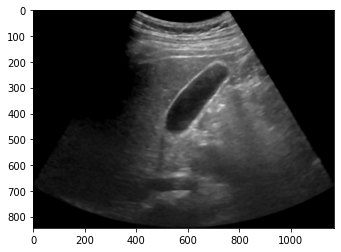



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (844, 1168) %%%%


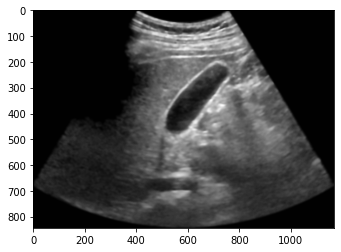



%%%% IMAGE: Default, SHAPE: (844, 1168) %%%%


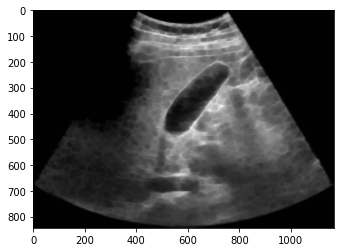

saving mask: 0001.png


$$$----Reading Image img/0002.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (845, 1275, 3) %%%%


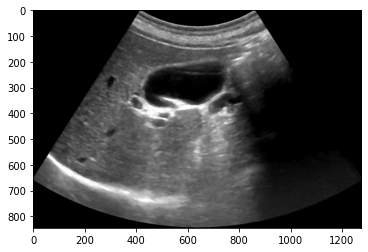



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (845, 1275) %%%%


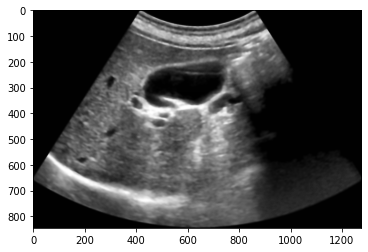



%%%% IMAGE: Default, SHAPE: (845, 1275) %%%%


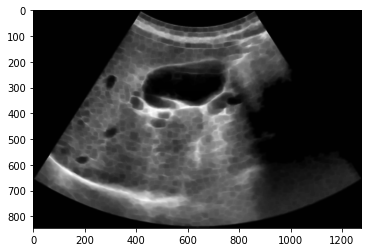

saving mask: 0002.png


$$$----Reading Image img/0003.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (773, 1310, 3) %%%%


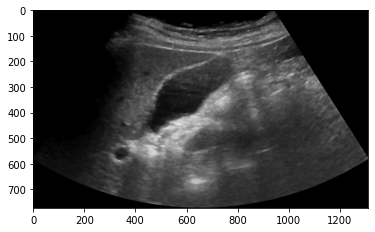



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (773, 1310) %%%%


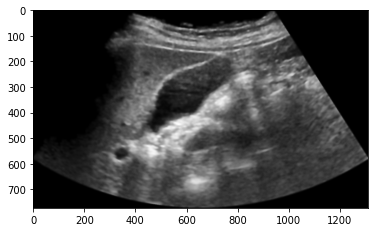



%%%% IMAGE: Default, SHAPE: (773, 1310) %%%%


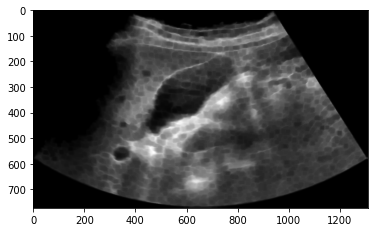

saving mask: 0003.png


$$$----Reading Image img/0004.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (844, 1229, 3) %%%%


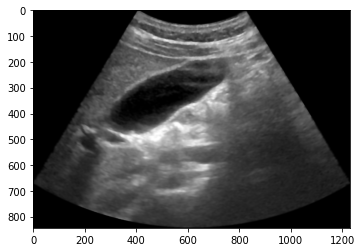



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (844, 1229) %%%%


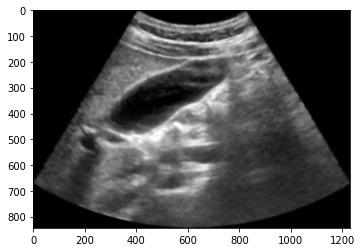



%%%% IMAGE: Default, SHAPE: (844, 1229) %%%%


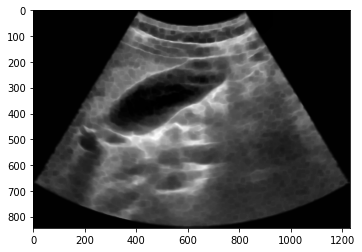

saving mask: 0004.png


$$$----Reading Image img/0005.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (843, 1246, 3) %%%%


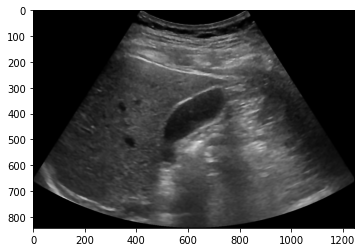



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (843, 1246) %%%%


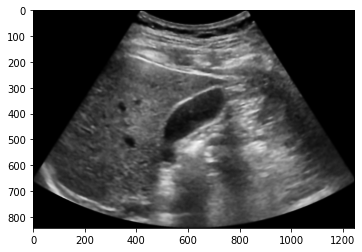



%%%% IMAGE: Default, SHAPE: (843, 1246) %%%%


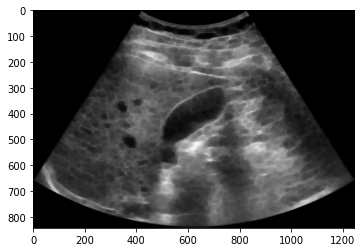

saving mask: 0005.png


$$$----Reading Image img/0006.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (844, 1132, 3) %%%%


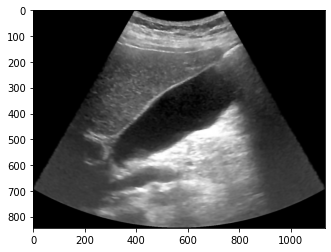



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (844, 1132) %%%%


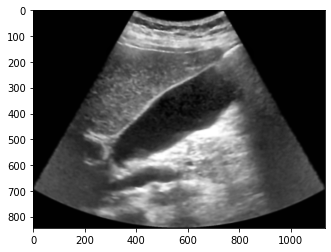



%%%% IMAGE: Default, SHAPE: (844, 1132) %%%%


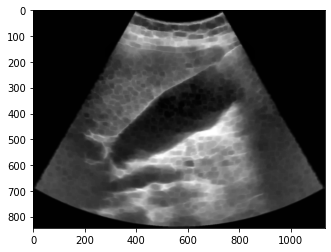

saving mask: 0006.png


$$$----Reading Image img/0007.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (844, 1174, 3) %%%%


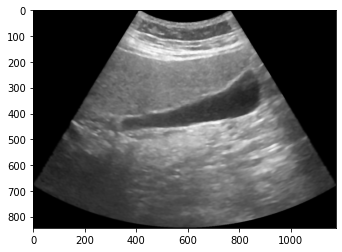



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (844, 1174) %%%%


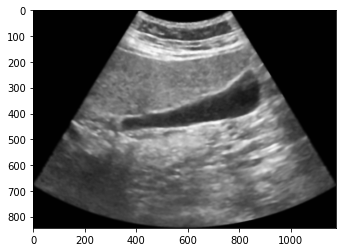



%%%% IMAGE: Default, SHAPE: (844, 1174) %%%%


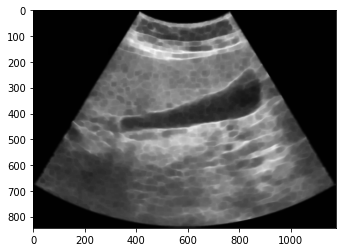

saving mask: 0007.png


$$$----Reading Image img/0008.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (843, 1259, 3) %%%%


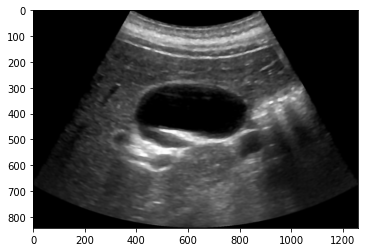



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (843, 1259) %%%%


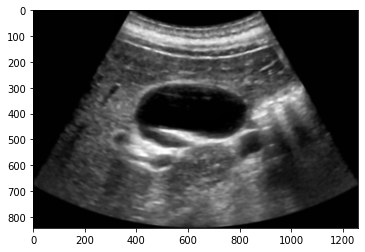



%%%% IMAGE: Default, SHAPE: (843, 1259) %%%%


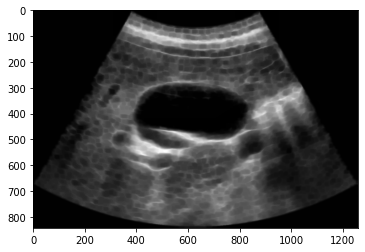

saving mask: 0008.png


$$$----Reading Image img/0009.jpg


%%%% IMAGE: NOISE_REMOVED, SHAPE: (842, 1268, 3) %%%%


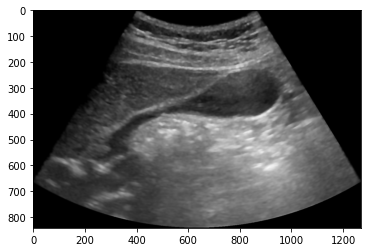



%%%% IMAGE: CONTRAST_IMPROVED, SHAPE: (842, 1268) %%%%


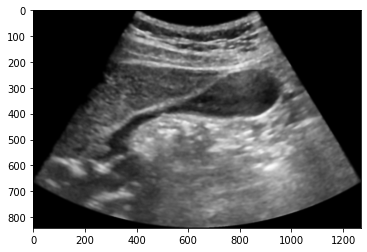



%%%% IMAGE: Default, SHAPE: (842, 1268) %%%%


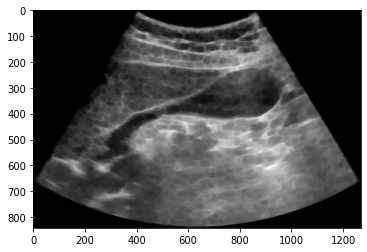

saving mask: 0009.png


In [1]:
import os
import cv2 as cv
import json
from glob import glob
import numpy as np
import argparse
import matplotlib.pyplot as plt


''' DEFINE GLOBAL VARIABLES '''
RECT_KERNEL_5X5 = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
RECT_KERNEL_3X3 = cv.getStructuringElement(cv.MORPH_RECT,(3,3))


''' UTIL FUNCTIONS '''
def hconcat_images(image_list):
    return cv.hconcat(image_list)

def show_image(img, title='Default', save=False):
    if img is None:
        print('Could not find image to show.')
    else:        
        print("\n\n%%%% IMAGE: {}, SHAPE: {} %%%%".format(title, img.shape))
        fig = plt.figure(0)
        plt.imshow(img, cmap='gray')
        plt.show()
        if save:
            fig.savefig("plots/"+name+".png", dpi=300, format="png")        
    return

def save_mask(mask, name):
    path = os.path.join(det_path,name+".png")
    print("saving mask: %s.png"%name)
    cv.imwrite(path,mask)
    return


''' CV FUNCTIONS '''

def convert_grayscale(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def bilateral_filter(img, d_val=9,color=100,space=100,border=cv.BORDER_REPLICATE):
    filtered_img = cv.bilateralFilter(img, d=d_val,sigmaColor=color,sigmaSpace=space,borderType=border)
    return filtered_img

def apply_clahe(img, limit=1, grid=(8,8)):
    if len(img.shape) != 2:
        img = convert_grayscale(img)
        print("Converted to Grayscale")
    
    clahe = cv.createCLAHE(clipLimit=limit, tileGridSize=grid)
    improved_hist_img = clahe.apply(img)

    return improved_hist_img

def erode_img(img, window_size = 5, iter=2):
    if window_size == 5:
        kernel = RECT_KERNEL_5X5
    else:
        kernel = RECT_KERNEL_3X3

    eroded_img = cv.erode(img, kernel, iterations = iter)

    return eroded_img

def dilate_img(img, window_size = 5, iter = 2):
    if window_size == 5:
        kernel = RECT_KERNEL_5X5
    else:
        kernel = RECT_KERNEL_3X3
    
    dilated_img = cv.dilate(img, kernel, iterations = iter)

    return dilated_img

def img_thresholding(img, th=60, color=255):

    _, th_img = cv.threshold(img,th,color,cv.THRESH_BINARY_INV)

    return th_img

def morphology_ex(img, type, window_size = 3, iter = 2):
    if window_size == 5:
        kernel = RECT_KERNEL_5X5
    else:
        kernel = RECT_KERNEL_3X3
    
    if type == "close":
        morph = cv.MORPH_CLOSE
    elif type == "open":
        morph = cv.MORPH_OPEN

    morphed_img = cv.morphologyEx(img, morph, kernel, iterations = iter) 

    return morphed_img

def canny_detection(img,th1=45, th2=45,aperture=3,l2_grad=False):

    canny_edges = cv.Canny(img,threshold1=th1, threshold2=th2,apertureSize=aperture,L2gradient=l2_grad)

    return canny_edges

def find_contours(img):

    hierarchy, contours = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)

    return hierarchy, contours

def get_gallbladder_ctr(ctr, top_n = 5, min_area = 10000, max_area = 150000):

    ctr = sorted(ctr, key=cv.contourArea) 
    big_ctr = ctr[-top_n:]
    filtered_big_ctr = []
    for c in big_ctr:
        area = cv.contourArea(c)
        if area > min_area and area < max_area:
            filtered_big_ctr.append(c)
    
    filtered_big_ctr = sorted(filtered_big_ctr, key=cv.contourArea)
    gb_ctr = filtered_big_ctr[-1]

    return gb_ctr

def approximate_contour(gb_ctr, sample_size = 33):

    poly_mask_gb = []    
    for i in range(int(len(gb_ctr)/sample_size)):
        poly_mask_gb.append(gb_ctr[i*sample_size])
    poly_mask_gb.append(gb_ctr[-1])
    poly_mask_gb = np.array(poly_mask_gb)

    return poly_mask_gb

def draw_contour(mask_ctr, height, width):

    canvas = np.zeros((height, width))
    cv.drawContours(canvas, [mask_ctr], -1, (255,255,255), -1)

    return canvas

def generate_mask(img):

    print("\n\n$$$----Reading Image", img)
    orig_image = cv.imread(img)
    (H,W,C) = orig_image.shape

    smooth_img = bilateral_filter(orig_image)
    show_image(smooth_img, "NOISE_REMOVED")

    grayscale_img = convert_grayscale(smooth_img)
    inc_contrast_img = apply_clahe(grayscale_img)
    inc_contrast_img = bilateral_filter(inc_contrast_img)
    show_image(inc_contrast_img, "CONTRAST_IMPROVED")

    erode_im = erode_img(inc_contrast_img, iter=2)
    show_image(erode_im)

    th_img = img_thresholding(erode_im)
    #show_image(th_img, "THRESHOLD")

    close_th = morphology_ex(th_img, type="close", iter=2)
    erode_close_th = erode_img(close_th, iter=2)
    #show_image(erode_close_th, "CLOSE_ERODE_THRESHOLD")

    contours, _ = find_contours(erode_close_th)
    gb_ctr = get_gallbladder_ctr(contours)
    enhanced_gb_ctr = approximate_contour(gb_ctr, sample_size = 32)
    
    gb_mask = draw_contour(enhanced_gb_ctr, H, W)
    gb_mask = dilate_img(gb_mask, iter=3)
    #show_image(gb_mask, "GALLBLADDER_MASK")
    
    save_mask(gb_mask, img.split("/")[-1][:-4])

    return

if __name__ == "__main__":
   
    
    img_path = "img"
    det_path = "det"
    images = glob(os.path.join(img_path,"*.jpg"))

    print("Total # images to process =", len(images))

    #for img in images:
    for img in images:
        generate_mask(img)
    #generate_mask(images[9])

In [16]:
cv.getStructuringElement(cv.MORPH_RECT,(3,3)), np.ones((3,3))

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=uint8),
 array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]))

In [ ]:
orig = cv.imread("img/0005.jpg")
show_image(orig)
image = cv.bilateralFilter(orig, d=9,sigmaColor=120,sigmaSpace=120,borderType=cv.BORDER_REPLICATE)
clahe = cv.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))
#show_image(image)
imp_cont_image = clahe.apply(cv.cvtColor(image,cv.COLOR_BGR2GRAY))

#show_image(imp_cont_image)
'''ret, th_img = cv.threshold(imp_cont_image,60,255,cv.THRESH_BINARY_INV)
ret, th_img_o = cv.threshold(image,65,255,cv.THRESH_BINARY_INV)
show_image(th_img_o)
show_image(th_img)'''

th2 = cv.adaptiveThreshold(imp_cont_image,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,5,2)
th3 = cv.adaptiveThreshold(imp_cont_image,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,5,2)
th2 = cv.bilateralFilter(th2, d=9,sigmaColor=120,sigmaSpace=120,borderType=cv.BORDER_REPLICATE)
th3 = cv.bilateralFilter(th3, d=9,sigmaColor=120,sigmaSpace=120,borderType=cv.BORDER_REPLICATE)
th2 = cv.morphologyEx(th2, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), iterations = 1) 
th3 = cv.morphologyEx(th3, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), iterations = 1) 
contours, hierarchy = cv.findContours(th2, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
ctr = sorted(contours, key=cv.contourArea) 
big_ctr = ctr[-5:]
filtered_big_ctr = []
for c in big_ctr:
    area = cv.contourArea(c)
    #print("Area",area)
    if area > 10000 and area < 150000:
        filtered_big_ctr.append(c)
    
filtered_big_ctr = sorted(filtered_big_ctr, key=cv.contourArea)
gb_ctr = filtered_big_ctr[-1]
output = np.zeros((orig.shape[0],orig.shape[1]))
poly_mask_gb = []
sampler = 33
for i in range(int(len(gb_ctr)/sampler)):
    poly_mask_gb.append(gb_ctr[i*sampler])
poly_mask_gb.append(gb_ctr[-1])

cv.drawContours(output, [np.array(poly_mask_gb)], -1, (255,255,255), -1)
output = cv.dilate(output, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=3)

show_image(output, save=True)


In [ ]:
orig = cv.imread("img/0005.jpg")
blur = cv.GaussianBlur(orig,(5,5),0)

# find normalized_histogram, and its cumulative distribution function
hist = cv.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

for i in xrange(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

# find otsu's threshold value with OpenCV function
ret, otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
show_image(otsu)